# PyMC4 implementation of logistic regression with spike-slab prior

Here I analyze the data posted at [PyMC4 github #247](https://github.com/pymc-devs/pymc4/issues/247#issue-619766402) and code in [the same thread](https://github.com/pymc-devs/pymc4/issues/247#issuecomment-630556063) using [rrkarim/pymc4:ccb29d8](https://github.com/rrkarim/pymc4/commit/ccb29d859a174ba9fcc96a6a4cfc07b38d3c80e5).

The data contains a simulated example of ~23,000 samples with observed binary response ($y \in \{0,1\}$), under logistic regression $\text{logit}(E(y)) = \alpha + X\beta$ where $X$ has 3 variables $x_1 \ne x_2 = x_3$, with effect $\beta_1 = 0, \beta_2 \ne 0, \beta_3 = 0$. 

We model variable $j$'s effect using a spike slab prior, $\beta_j \sim \pi_{j} \delta_0 + (1 - \pi_{j}) N (\mu, \sigma^2)$. Due to simulation settings we expect posterior of $\pi$ is close to 0 for $x_1$. Since  $x_2$ and $x_3$ are identical, we expect posterior of $\pi$ also identical for $x_2$ and $x_3$, and are both 0.5.

The code took about 1hr to run, for 4 chains each 10,000 iterations. 

In [1]:
import os, pickle
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
import numpy as np
import pymc4 as pm
from pymc4.mcmc.samplers import NUTS, RandomWalkM

In [15]:
@pm.model
def spike_slab_logistic(y, X, pi0=0.5, mu=0, sigma=1, lower=-1, upper=1):
    xi = yield pm.Bernoulli('xi', pi0 * tf.ones(X.shape[1], 'float32'))
    beta_offset = yield pm.Normal('beta_offset', tf.zeros(X.shape[1], 'float32'), tf.ones(X.shape[1], 'float32'))
    beta = yield pm.Deterministic("beta", mu + beta_offset * sigma)
    alpha_offset = yield pm.Uniform("alpha_offset", -1, 1)
    alpha = yield pm.Deterministic("alpha", lower + (alpha_offset + 1) / 2 * (upper - lower))
    # this is the line in question; without explicit casting,
    # z = tf.linalg.matvec(X,  xi * beta)
    # will not work
    z = tf.linalg.matvec(X, tf.cast(xi, tf.float32) * beta) + alpha
    yield pm.Bernoulli('y_obs', tf.math.sigmoid(z), observed = y)

In [24]:
iteration = 10000
tune_prop = 0.25
n_chain = 3
n_thread = 4

In [3]:
pi0 = 0.051366009925488
mu = 0.783230896500752
sigma = 0.816999481742865
lower = -2.94
upper = 0

In [4]:
cwd = os.path.expanduser("~/GIT/cnv-gene-mapping/data/deletion_simu_30_shape0.777_scale0.843")
X = np.loadtxt(f'{cwd}/block_1151_1159/deletion.genes.block30.for_simu.sample.combined.genes.block_1151_1159.gz', dtype=np.float32)
X = X[:, :3]
y = np.loadtxt(f'{cwd}/deletion.genes.block30.for_simu.sample.combined.y.gz', dtype=np.int32)

In [25]:
tf.config.threading.set_intra_op_parallelism_threads(n_thread)
model = spike_slab_logistic(y, tf.constant(X), pi0, mu, sigma, lower, upper)
trace = pm.sample(
        model, step_size=0.01, num_chains=n_chain, num_samples=iteration,
        burn_in=int(tune_prop*iteration), nuts_kwargs={},
        xla=False, use_auto_batching=True,
        sampler_type="compound", 
        sampler_methods=[
        ("xi", RandomWalkM), 
        ("beta", NUTS),
        ("alpha", NUTS),
        ("beta_offset", NUTS),
        ("alpha_offset", NUTS)
        ]
    )

## Result summary

Posteriors are $\tilde{\pi}_{1} = 0.055325$, $\tilde{\pi}_{2} = 0.51185$, $\tilde{\pi}_{3} = 0.54485$. I ran two replicates the results are similar. It roughly makes sense. But $\tilde{\pi}_{1}$ is a bit off --- it is close to prior (=0.05) in both runs but I expect it to be zero. 

Also problematic is the intercept $\alpha$. Currently the posterior remains uniform but I expect it to be close to zero because we have 50% zeros and 50% ones in $y$.

The implementation in PyMC3 along the lines of [this post](https://www.kaggle.com/melondonkey/bayesian-spike-and-slab-in-pymc3) gives comparable result for $\tilde{\pi}_{2}$ and $\tilde{\pi}_{3}$ but $\tilde{\pi}_{1}$ is closer to zero (about 0.01). $\alpha$ is clearly not uniform and is indeed close to zero (-0.01). The only issue is that implementation with PyMC3 is a quite a bit slower so I hope PyMC4 can work as expected.

See below for details.

## Trace plots

In [8]:
import arviz as az

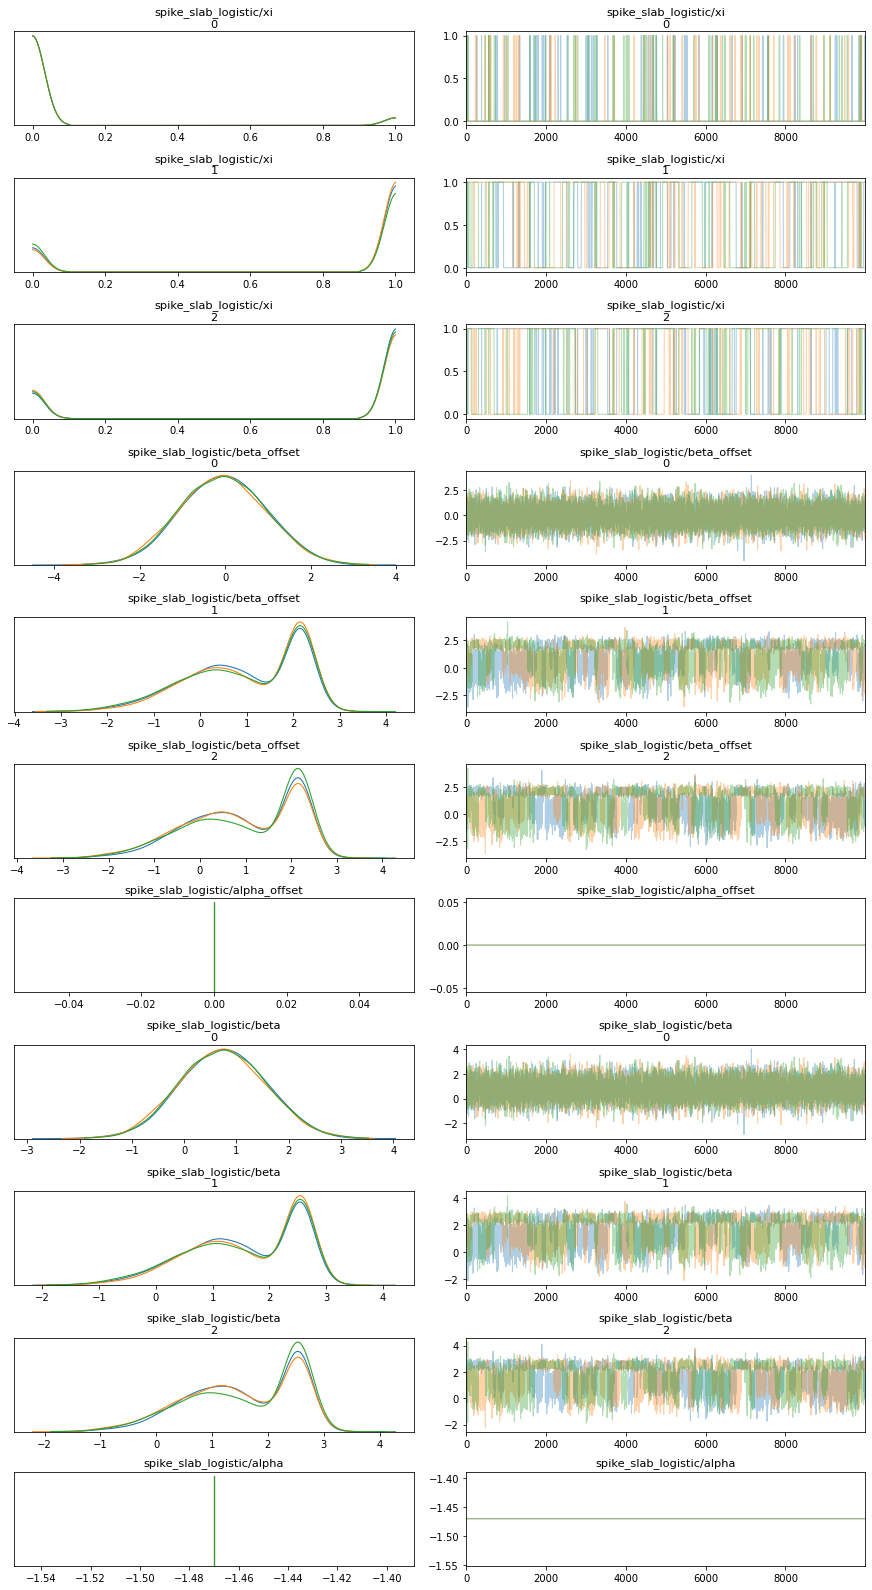

In [26]:
status = az.plot_trace(trace)

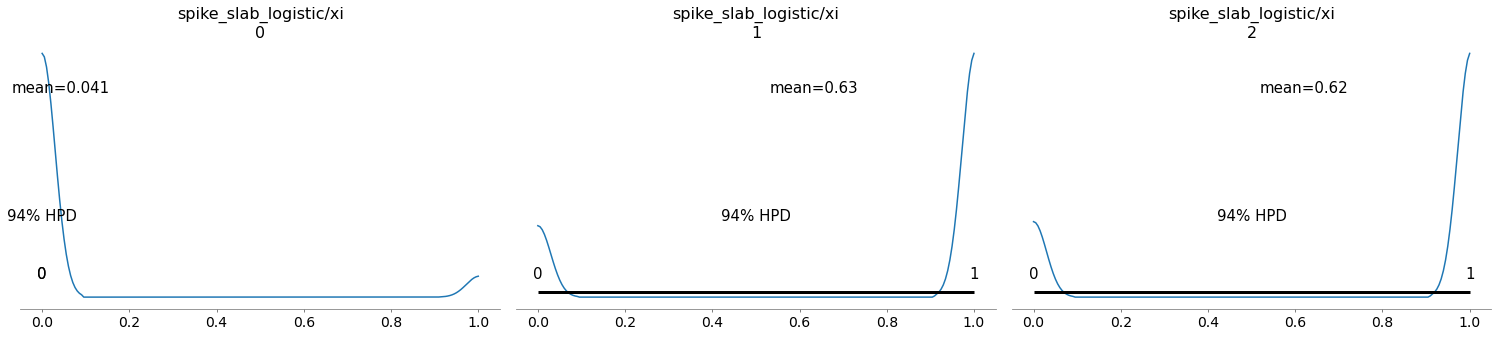

In [27]:
status = az.plot_posterior(trace, var_names="spike_slab_logistic/xi")

## Posterior estimate of $\pi_0$

In [28]:
import numpy as np
xi = np.array(trace.posterior['spike_slab_logistic/xi'])

In [29]:
np.mean(np.mean(xi, axis=1), axis=0)

array([0.0414   , 0.6322   , 0.6192667], dtype=float32)

In [30]:
alpha = np.array(trace.posterior['spike_slab_logistic/alpha'])
np.mean(np.mean(alpha, axis=0))

-1.4699998

## TODO

1. Formal divergence check
2. Effective sample size report